<a href="https://colab.research.google.com/github/nandinib1999/image_segmentation/blob/master/InstanceSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np
import cv2
import random

In [2]:
!pip install colour
from colour import Color

In [3]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [0]:
# Random Colour Mask Generator for Images 
def colour_masks(image):
  colours = []
  colours_names = ['cyan', 'coral', 'limegreen', 'chartreuse', 'aqua', 'magenta', 'orange', 'yellow', 'deeppink', 'darkviolet']
  for color in colours_names:
    cl = Color(color)
    rgb = [round(val*255, 0) for val in cl.rgb]
    colours.append(rgb)
  red = np.zeros_like(image).astype(np.uint8)
  green = np.zeros_like(image).astype(np.uint8)
  blue = np.zeros_like(image).astype(np.uint8)
  red[image == 1], green[image == 1], blue[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([red, green, blue], axis=2)
  return coloured_mask

In [0]:
COCO_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [6]:
!git clone https://github.com/nandinib1999/image_segmentation

fatal: destination path 'image_segmentation' already exists and is not an empty directory.


In [0]:
# Loading Image and running it through the model
img = Image.open('/content/image_segmentation/images.jpg')
transform = T.Compose([T.ToTensor()])
img = transform(img)
pred = model([img])

In [8]:
# selecting predicted masks above a threshold value
masks = (pred[0]['masks']>0.7).squeeze().detach().cpu().numpy()
masks.shape

(5, 489, 870)

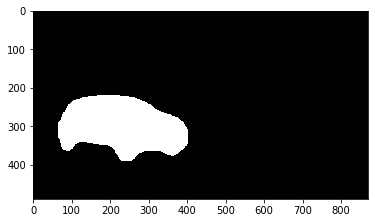

In [9]:
plt.imshow(masks[0], cmap='gray')
plt.show()

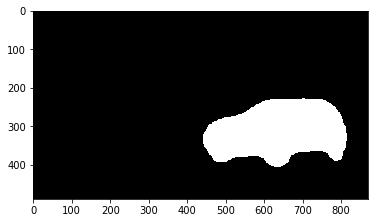

In [10]:
plt.imshow(masks[1], cmap='gray') 
plt.show()

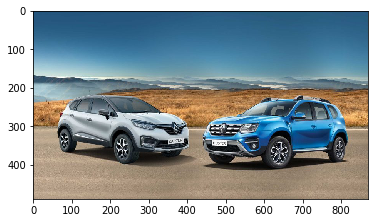

In [11]:
# visualizing the original image
import matplotlib.image as pltimg
img=pltimg.imread('/content/image_segmentation/images.jpg')
plt.imshow(img)
plt.show()

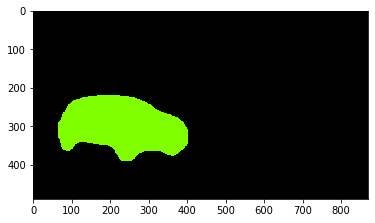

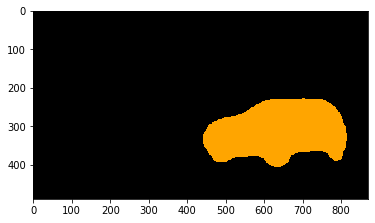

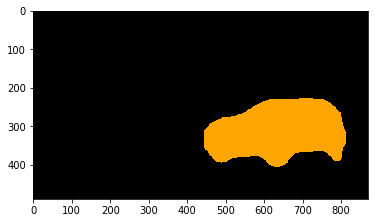

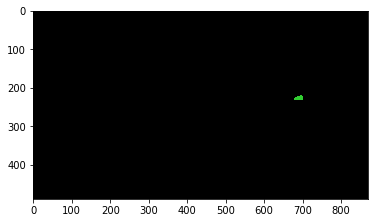

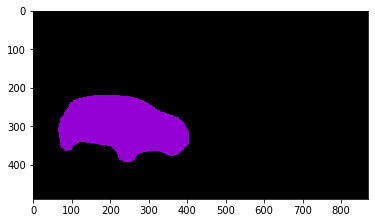

In [12]:
# visualizing the colored predicted masks above threshold value
for mask in masks:
  tmp_mask = colour_masks(mask)
  plt.imshow(tmp_mask)
  plt.show()

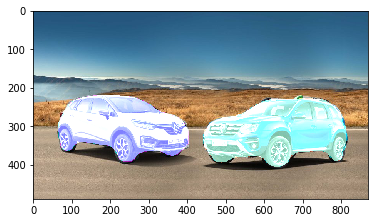

In [13]:
for mask in masks:
  color_mask = colour_masks(mask)
  img = cv2.addWeighted(img, 1, color_mask, 0.5, 0)

plt.imshow(img)

In [0]:
def predict(img_path, threshold):
  img = Image.open(img_path)
  with torch.no_grad():
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])

    # scores of predicted classes
    pred_scores = list(pred[0]['scores'].numpy())
    pred_score = [x for x in pred_scores if x>threshold]

    # number of predictions with score above threshold value
    num_pred = len(pred_score)

    # coordinates of predicted bounding box
    pred_boxes = [[(vrtx[0], vrtx[1]), (vrtx[2], vrtx[3])] for vrtx in list(pred[0]['boxes'].numpy())]

    # predicted masks above threshold
    pred_masks = (pred[0]['masks']>threshold).squeeze().numpy()

    # predicted class names
    pred_class = [COCO_CATEGORY_NAMES[indx] for indx in list(pred[0]['labels'].numpy())]

    masks = pred_masks[:num_pred]
    pred_boxes = pred_boxes[:num_pred]
    pred_class = pred_class[:num_pred]
  return masks, pred_boxes, pred_class, pred_score

In [0]:
def instance_segmentation_runner(img_path, threshold=0.5, rect=3, font_size=2, text=2):
  masks, boxes, pred_cls, pred_score = predict(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # creating colored masks of every predicted mask
  for i in range(len(masks)):
    rgb_mask = colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    # draw bounding box with the predicted coordinates 
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect)
    # add predicted label with score as text 
    cv2.putText(img,pred_cls[i]+' '+str(round(pred_score[i],2)), boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, font_size, (0,0,255),thickness=text)
  plt.figure(figsize=(10,20))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

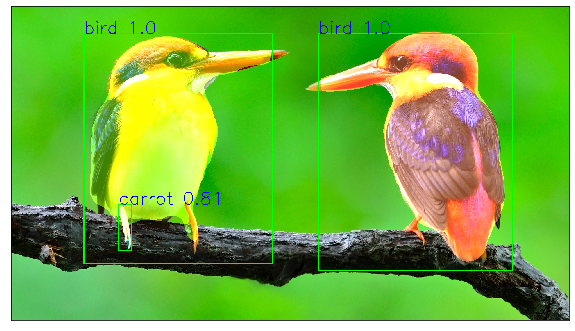

In [16]:
instance_segmentation_runner('/content/image_segmentation/birds.jpg')

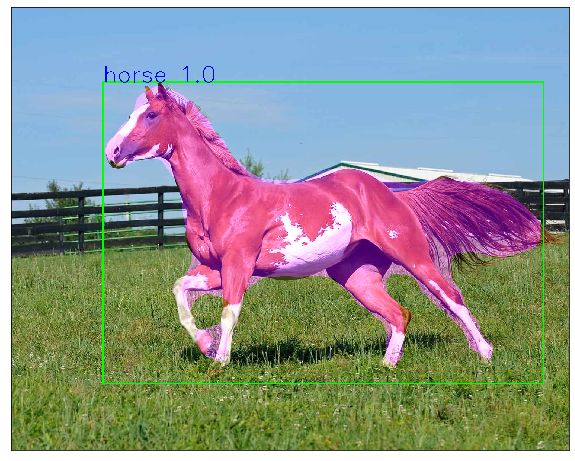

In [17]:
instance_segmentation_runner('/content/image_segmentation/horse.jpg')

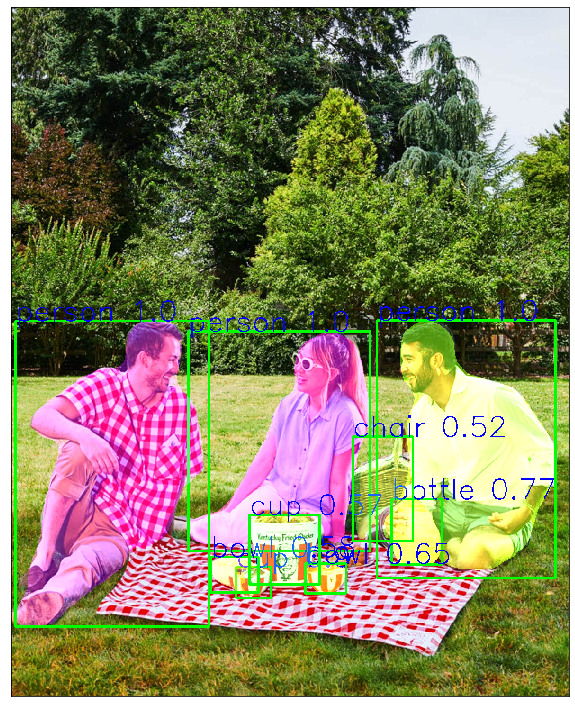

In [18]:
instance_segmentation_runner('/content/image_segmentation/picnic.jpg')

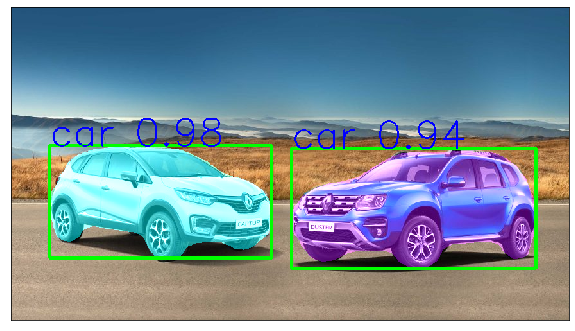

In [19]:
instance_segmentation_runner('/content/image_segmentation/images.jpg')